## Flight Price Prediction

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation and EDA

In [95]:
df = pd.read_csv(r"../Data/data.csv")

In [96]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [97]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 7.1 MB


In [98]:
df.shape

(10683, 11)

In [99]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [100]:
# The row with missing value has Source of Delhi and Destination of Cochin

df[df['Route'].isna()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [101]:
# There are 4537 samples with the mentioned source and destination. 
# We need to narrow our selection further to come up with the reasonable value for no. stops for the missing value.

filt = (df['Source']=='Delhi') & (df['Destination']=='Cochin')
df[filt]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
9,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,11:25,19:15,7h 50m,1 stop,No info,8625
10,Air India,1/06/2019,Delhi,Cochin,DEL → BLR → COK,09:45,23:00,13h 15m,1 stop,No info,8907
15,Air India,3/03/2019,Delhi,Cochin,DEL → AMD → BOM → COK,16:40,19:15 04 Mar,26h 35m,2 stops,No info,14011
16,SpiceJet,15/04/2019,Delhi,Cochin,DEL → PNQ → COK,08:45,13:15,4h 30m,1 stop,No info,5830
...,...,...,...,...,...,...,...,...,...,...,...
10669,Air India,15/06/2019,Delhi,Cochin,DEL → BOM → COK,08:00,19:15,11h 15m,1 stop,No info,9929
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150
10673,Jet Airways,27/05/2019,Delhi,Cochin,DEL → AMD → BOM → COK,13:25,04:25 28 May,15h,2 stops,No info,16704
10676,Multiple carriers,1/05/2019,Delhi,Cochin,DEL → BOM → COK,10:20,19:00,8h 40m,1 stop,No info,9794


In [102]:
df['Duration'].value_counts()

Duration
2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: count, Length: 368, dtype: int64

In [103]:
def correct_duration(text):
    if 'm' not in text:
        text += ' 0m'
    if 'h' not in text:
        text = '0h ' + text
    return text

In [104]:
def duration_to_min(text):
    temp = text.split(' ')
    hour = int(temp[0][:-1])
    min = int(temp[1][:-1])
    total = hour*60 + min
    return total

In [105]:
df['Duration'] = df['Duration'].apply(correct_duration)

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h 0m,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [106]:
df['Duration_min'] = df['Duration'].apply(duration_to_min)

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_min
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,170
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,445
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h 0m,2 stops,No info,13882,1140
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,325
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,285


In [107]:
# The data has been extracted from Duration feature. It can be dropped now.

df = df.drop('Duration', axis=1)

<Axes: xlabel='Duration_min', ylabel='Percent'>

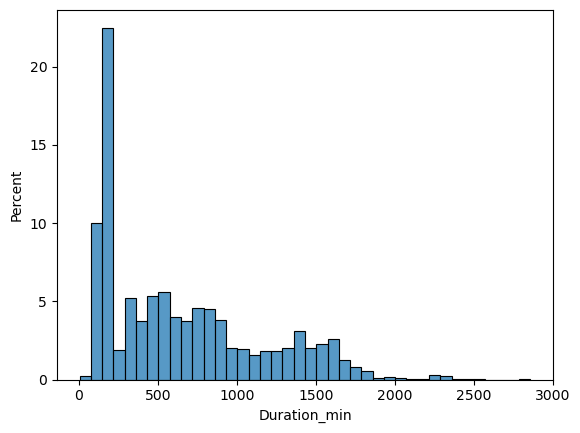

In [108]:
# It can be seen that 50% of flights have less than 500 mins duration, and 75% take less than 1000 mins. Moreover, maximum flight duration goes to near 3000 mins.

sns.histplot(data=df, x='Duration_min', bins=40, stat='percent')

<Axes: xlabel='Duration_min'>

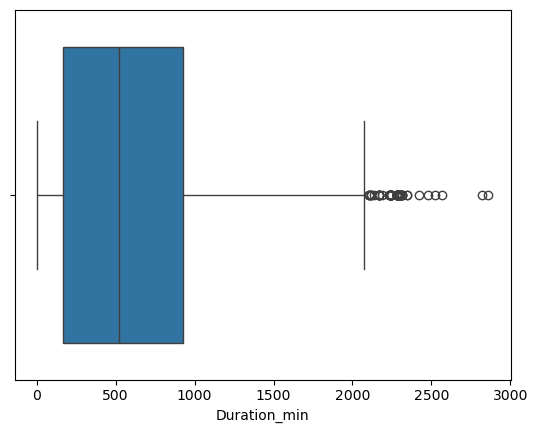

In [109]:
sns.boxplot(data=df, x='Duration_min')

In [110]:
# Now, we can filter down the data to figure out what the reasonable value would be for the no. of stops for our missing value.
# It can be seen the majority of values show '1 stop', so we opt for 1 stop for our missing value.

filt = (df['Source']=='Delhi') & (df['Destination']=='Cochin') & (df['Duration_min']>1320) & (df['Price']<8000)
df[filt]['Total_Stops'].value_counts()

Total_Stops
1 stop     54
2 stops     9
Name: count, dtype: int64

In [111]:
df.at[9039, 'Total_Stops'] = '1 stop'

In [112]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Total_Stops        0
Additional_Info    0
Price              0
Duration_min       0
dtype: int64

In [113]:
# What is the most traveled route?

df['Route'].value_counts()[:10]

Route
DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
CCU → DEL → BLR           565
BLR → BOM → DEL           402
MAA → CCU                 381
DEL → HYD → COK           326
DEL → JAI → BOM → COK     240
Name: count, dtype: int64

<Axes: xlabel='Route'>

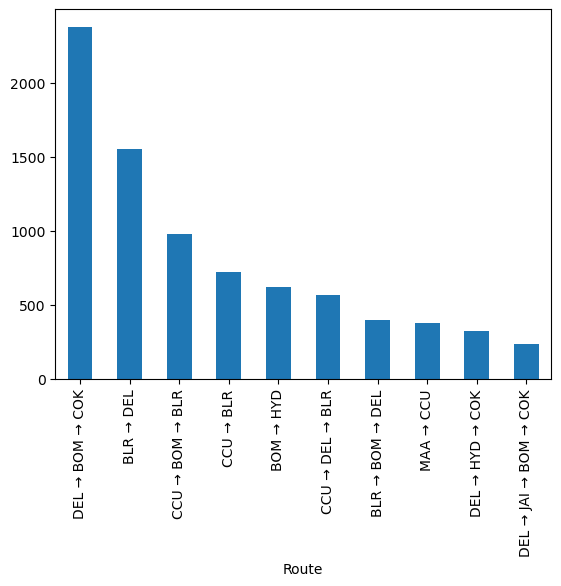

In [114]:
df['Route'].value_counts()[:10].plot(kind='bar')

In [115]:
# What is the most used airline for the most used route?

filt = df['Route']=='DEL → BOM → COK'
df[filt]['Airline'].value_counts()

Airline
Multiple carriers                    1020
Jet Airways                           875
IndiGo                                302
Air India                             117
GoAir                                  49
Multiple carriers Premium economy      13
Name: count, dtype: int64

In [116]:
# The Route feature provides the similar information as no. of stops feature. So, the feature will be dropped here.

df = df.drop('Route', axis=1)

In [117]:
# For Additional_Info feature column, around 80% of the samples, the column has no information, so we will be dropping this column.

df['Additional_Info'].value_counts()/len(df['Additional_Info'])*100

Additional_Info
No info                         78.114762
In-flight meal not included     18.552841
No check-in baggage included     2.995413
1 Long layover                   0.177853
Change airports                  0.065525
Business class                   0.037443
No Info                          0.028082
1 Short layover                  0.009361
Red-eye flight                   0.009361
2 Long layover                   0.009361
Name: count, dtype: float64

In [118]:
df = df.drop('Additional_Info', axis=1)

In [119]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Price,Duration_min
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,non-stop,3897,170
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,2 stops,7662,445
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,2 stops,13882,1140
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,1 stop,6218,325
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,21:35,1 stop,13302,285


In [120]:
df['Total_Stops'].value_counts().index

Index(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], dtype='object', name='Total_Stops')

In [121]:
total_stop_dict = {'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}

In [122]:
df['Total_Stops'] = df['Total_Stops'].map(total_stop_dict)

df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Price,Duration_min
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,0,3897,170
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,2,7662,445
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,2,13882,1140
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,1,6218,325
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,21:35,1,13302,285


<Axes: xlabel='Total_Stops', ylabel='percent'>

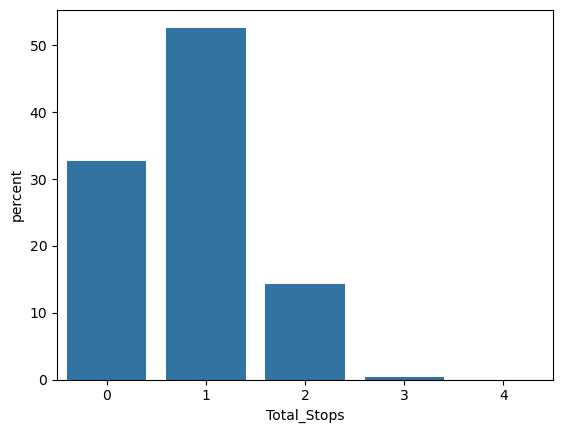

In [123]:
# What is the distribution of total stops for all the flights?

sns.countplot(data=df.sort_values('Total_Stops'), x='Total_Stops', stat='percent')

In [124]:
df['Dep_hour'] = df['Dep_Time'].apply(lambda x: int(x[:2]))
df['Dep_min'] = df['Dep_Time'].apply(lambda x: int(x[3:5]))

df['Arrival_hour'] = df['Arrival_Time'].apply(lambda x: int(x[:2]))
df['Arrival_min'] = df['Arrival_Time'].apply(lambda x: int(x[3:5]))

df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,0,3897,170,22,20,1,10
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,2,7662,445,5,50,13,15
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,2,13882,1140,9,25,4,25
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,1,6218,325,18,5,23,30
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,21:35,1,13302,285,16,50,21,35


In [125]:
# Departure hour covers all 24 hours of a day

df['Dep_hour'].unique()

array([22,  5,  9, 18, 16,  8, 11, 20, 21, 17, 14,  4,  7, 10, 15,  6, 19,
       23, 13,  2, 12,  0,  1,  3], dtype=int64)

In [126]:
df = df.drop(['Dep_Time','Arrival_Time'], axis=1)

df.head()

,Airline,Date_of_Journey,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,24/03/2019,Banglore,New Delhi,0,3897,170,22,20,1,10
1,Air India,1/05/2019,Kolkata,Banglore,2,7662,445,5,50,13,15
2,Jet Airways,9/06/2019,Delhi,Cochin,2,13882,1140,9,25,4,25
3,IndiGo,12/05/2019,Kolkata,Banglore,1,6218,325,18,5,23,30
4,IndiGo,01/03/2019,Banglore,New Delhi,1,13302,285,16,50,21,35


<Axes: xlabel='Dep_hour', ylabel='Percent'>

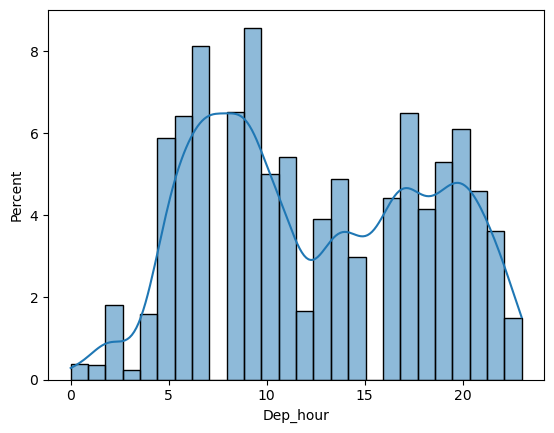

In [127]:
sns.histplot(data=df.sort_values('Dep_hour'), x='Dep_hour', kde=True, stat='percent')

In [128]:
# The flights are segmented according to their departure times

def departure_segment(departure_hour):

    if 0 < departure_hour <= 4:
        return 'Late night'
    elif 4 < departure_hour <= 8:
        return 'Early morning'
    elif 8 < departure_hour <= 12:
        return 'Morning'
    elif 12 < departure_hour <= 16:
        return 'Afternoon'
    elif 16 < departure_hour <= 20:
        return 'Evening'
    else:
        return 'Night'


In [129]:
df2 = df['Dep_hour'].apply(departure_segment)

df2 = pd.DataFrame(df2)

df2.columns = ['Departure_segment']

df2.head()

,Departure_segment
0,Night
1,Early morning
2,Morning
3,Evening
4,Afternoon


<Axes: xlabel='Departure_segment', ylabel='percent'>

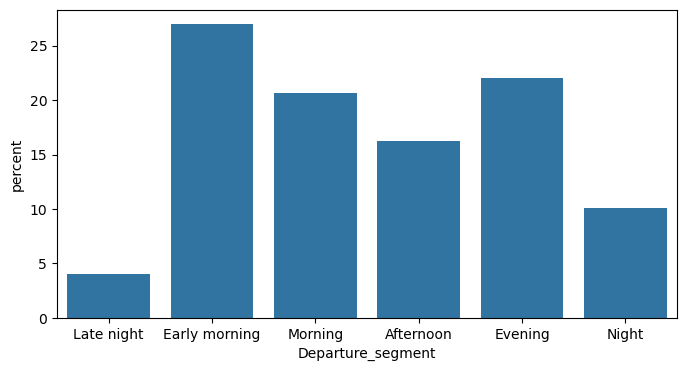

In [130]:
# Distribution of flights according to their departure segment

plt.figure(figsize=(8,4))
sns.countplot(data=df2, x='Departure_segment', order=['Late night', 'Early morning', 'Morning', 'Afternoon', 'Evening', 'Night'], stat='percent')

In [131]:
df['Month_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.month
df['Day_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.day

df.head()

,Airline,Date_of_Journey,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey
0,IndiGo,24/03/2019,Banglore,New Delhi,0,3897,170,22,20,1,10,3,24
1,Air India,1/05/2019,Kolkata,Banglore,2,7662,445,5,50,13,15,5,1
2,Jet Airways,9/06/2019,Delhi,Cochin,2,13882,1140,9,25,4,25,6,9
3,IndiGo,12/05/2019,Kolkata,Banglore,1,6218,325,18,5,23,30,5,12
4,IndiGo,01/03/2019,Banglore,New Delhi,1,13302,285,16,50,21,35,3,1


<Axes: xlabel='Month_of_Journey', ylabel='count'>

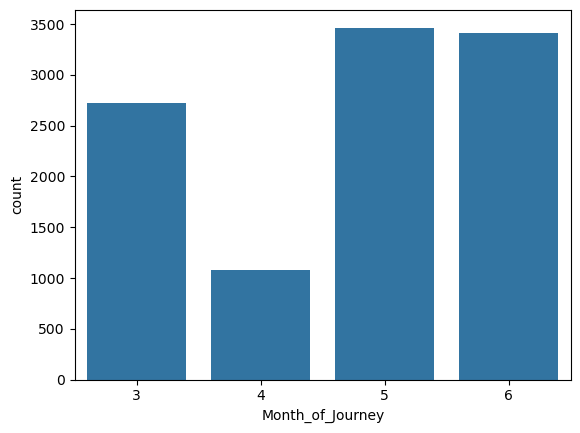

In [132]:
# It can be seen the data is collected between March and June

sns.countplot(data=df, x='Month_of_Journey')

In [133]:
df['Year_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.year

df.head()

,Airline,Date_of_Journey,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey,Year_of_Journey
0,IndiGo,24/03/2019,Banglore,New Delhi,0,3897,170,22,20,1,10,3,24,2019
1,Air India,1/05/2019,Kolkata,Banglore,2,7662,445,5,50,13,15,5,1,2019
2,Jet Airways,9/06/2019,Delhi,Cochin,2,13882,1140,9,25,4,25,6,9,2019
3,IndiGo,12/05/2019,Kolkata,Banglore,1,6218,325,18,5,23,30,5,12,2019
4,IndiGo,01/03/2019,Banglore,New Delhi,1,13302,285,16,50,21,35,3,1,2019


In [134]:
df['Year_of_Journey'].unique()

array([2019])

In [135]:
# according to the output of the last cell, the journeys all happened in 2019 and it doesn't provide any useful information for our ML model. So, it will be dropped.

df = df.drop('Year_of_Journey', axis=1)

df.head()

,Airline,Date_of_Journey,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey
0,IndiGo,24/03/2019,Banglore,New Delhi,0,3897,170,22,20,1,10,3,24
1,Air India,1/05/2019,Kolkata,Banglore,2,7662,445,5,50,13,15,5,1
2,Jet Airways,9/06/2019,Delhi,Cochin,2,13882,1140,9,25,4,25,6,9
3,IndiGo,12/05/2019,Kolkata,Banglore,1,6218,325,18,5,23,30,5,12
4,IndiGo,01/03/2019,Banglore,New Delhi,1,13302,285,16,50,21,35,3,1


In [136]:
# The necessary data is extracted from the Date_of_journey column. it can be dropped now.
df = df.drop('Date_of_Journey', axis=1)

df.head()

,Airline,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey
0,IndiGo,Banglore,New Delhi,0,3897,170,22,20,1,10,3,24
1,Air India,Kolkata,Banglore,2,7662,445,5,50,13,15,5,1
2,Jet Airways,Delhi,Cochin,2,13882,1140,9,25,4,25,6,9
3,IndiGo,Kolkata,Banglore,1,6218,325,18,5,23,30,5,12
4,IndiGo,Banglore,New Delhi,1,13302,285,16,50,21,35,3,1


In [137]:
# What is the most used airline?

df['Airline'].value_counts()

# Jet Airways has the most number of flights

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

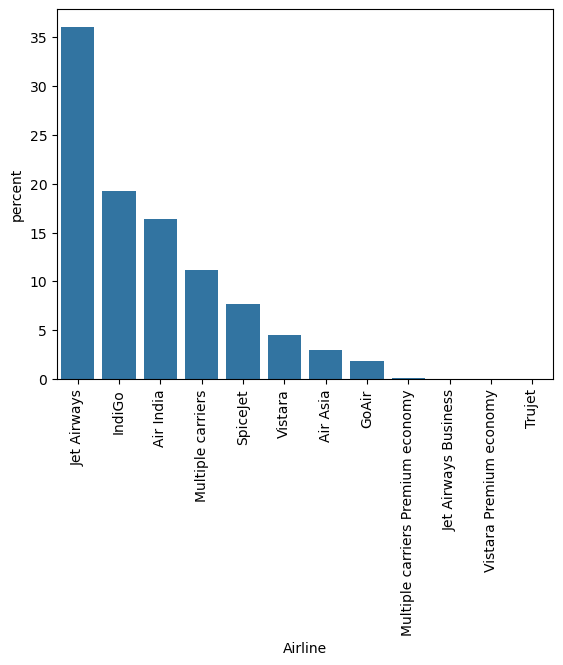

In [138]:
# visualization with percentage

sns.countplot(data=df, x='Airline', stat='percent', order=df['Airline'].value_counts().index)
plt.xticks(rotation=90);

In [139]:
# Preparing for Target guided ordinal encoding of the Airlines

df.groupby('Airline')['Price'].mean().sort_values()

Airline
Trujet                                4140.000000
SpiceJet                              4338.284841
Air Asia                              5590.260188
IndiGo                                5673.682903
GoAir                                 5861.056701
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Air India                             9611.210616
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
Jet Airways                          11643.923357
Jet Airways Business                 58358.666667
Name: Price, dtype: float64

In [140]:
df.groupby('Airline')['Price'].mean().sort_values().index

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')

In [141]:
# The airlines are encoded according to the mean price values, from lowest to highest price.

airline_dict = {'Trujet':0, 'SpiceJet':1, 'Air Asia':2, 'IndiGo':3, 'GoAir':4, 'Vistara':5,
       'Vistara Premium economy':6, 'Air India':7, 'Multiple carriers':8,
       'Multiple carriers Premium economy':9, 'Jet Airways':10,
       'Jet Airways Business':11}

In [142]:
# These labels will be used later

airline_labels = labels=df['Airline'].value_counts().index

In [143]:
df['Airline'] = df['Airline'].map(airline_dict)

df.head()

,Airline,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey
0,3,Banglore,New Delhi,0,3897,170,22,20,1,10,3,24
1,7,Kolkata,Banglore,2,7662,445,5,50,13,15,5,1
2,10,Delhi,Cochin,2,13882,1140,9,25,4,25,6,9
3,3,Kolkata,Banglore,1,6218,325,18,5,23,30,5,12
4,3,Banglore,New Delhi,1,13302,285,16,50,21,35,3,1


<Axes: ylabel='count'>

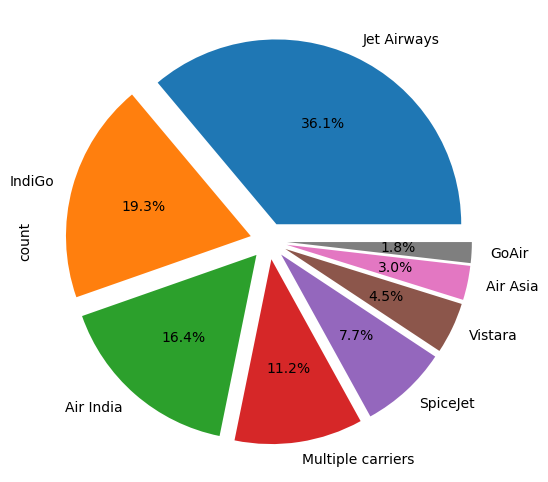

In [144]:
# Airlines with less than 1% share are eliminated.
# Jec Airways has the highest no. of flights followed by IndiGo and Air India.

plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
df['Airline'].value_counts()[:-4].plot(kind='pie', autopct='%1.1f%%', explode=[.1,.1,.1,.1,.1, .1,.1,.1], labels=airline_labels[:-4])

In [145]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey
0,3,Banglore,New Delhi,0,3897,170,22,20,1,10,3,24
1,7,Kolkata,Banglore,2,7662,445,5,50,13,15,5,1
2,10,Delhi,Cochin,2,13882,1140,9,25,4,25,6,9
3,3,Kolkata,Banglore,1,6218,325,18,5,23,30,5,12
4,3,Banglore,New Delhi,1,13302,285,16,50,21,35,3,1


In [146]:
# Let's examine the Source feature.

df['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [147]:
df['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [148]:
df = pd.get_dummies(df, columns=['Source', 'Destination'], drop_first=True, dtype=int)

<Axes: xlabel='Price', ylabel='Count'>

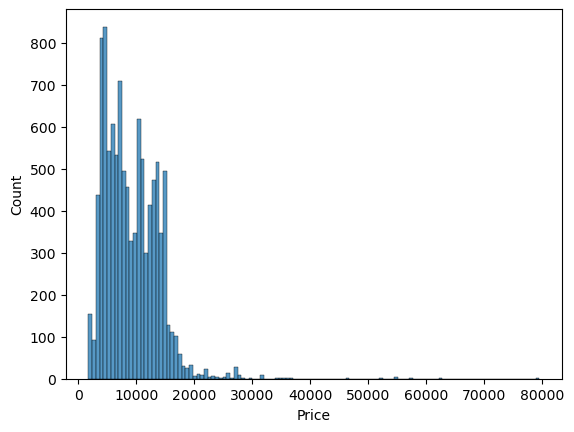

In [149]:
# Dealing with outliers

sns.histplot(data=df, x='Price')

<Axes: xlabel='Price'>

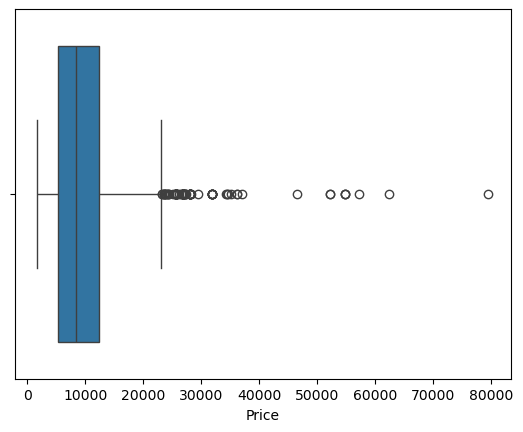

In [150]:
# Right skewness is evident in the Price feature
sns.boxplot(data=df, x='Price')

In [151]:
q1 = df['Price'].quantile(.25)
q3 = df['Price'].quantile(.75)

IQR = q3 - q1

minimum = q1 - 1.5 * IQR
maximum = q3 + 1.5 * IQR

In [152]:
maximum

23017.0

In [153]:
len(df[df['Price']>maximum])

94

In [154]:
len(df[df['Price']>40_000])

9

In [155]:
# We will be replacing price values more than 40,000 (outliers) with median value.

# The median is a robust measure of central tendency, meaning it is less sensitive to extreme values (outliers) than the mean. 
# In a right-skewed distribution, outliers are typically large values that can heavily influence the mean, but they have 
# little to no effect on the median.

# Many statistical models assume normality or at least less extreme skewness in the data. By replacing outliers with the median, 
# you can reduce the skewness and make the data more symmetric, which often improves the performance of these models.

# Outliers in right-skewed data may represent errors, anomalies, or rare events that are not representative of the general population. 
# Replacing them with the median ensures that they do not disproportionately affect your analysis.

df['Price'] = np.where(df['Price']>40_000, df['Price'].median(), df['Price'])

In [156]:
df.head()

,Airline,Total_Stops,Price,Duration_min,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Month_of_Journey,Day_of_Journey,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,3,0,3897.0,170,22,20,1,10,3,24,0,0,0,0,0,0,0,0,1
1,7,2,7662.0,445,5,50,13,15,5,1,0,0,1,0,0,0,0,0,0
2,10,2,13882.0,1140,9,25,4,25,6,9,0,1,0,0,1,0,0,0,0
3,3,1,6218.0,325,18,5,23,30,5,12,0,0,1,0,0,0,0,0,0
4,3,1,13302.0,285,16,50,21,35,3,1,0,0,0,0,0,0,0,0,1


In [157]:
X = df.drop('Price', axis=1)

y = df['Price']

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [160]:
X_train.shape

(8012, 18)

In [161]:
X_test.shape

(2671, 18)

In [162]:
from sklearn.preprocessing import StandardScaler

In [163]:
scaler = StandardScaler()

In [164]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Modeling

In [165]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

In [166]:
#"""
models_dict = {'DecisionTreeRegressor':DecisionTreeRegressor(),
               'RandomForestRegressor':RandomForestRegressor(),
               'SVR':SVR(),
               'LinearRegression':LinearRegression(),
               'AdaBoostRegressor':AdaBoostRegressor(),
               'GradientBoostingRegressor':GradientBoostingRegressor()
               }
#"""

In [167]:
"""
models_dict = {
               'RandomForestRegressor':RandomForestRegressor()
              }
"""

"\nmodels_dict = {\n               'RandomForestRegressor':RandomForestRegressor()\n              }\n"

In [168]:
models = list(models_dict.keys())

models

['DecisionTreeRegressor',
 'RandomForestRegressor',
 'SVR',
 'LinearRegression',
 'AdaBoostRegressor',
 'GradientBoostingRegressor']

In [169]:
# Evaluate the baseline performance of models

def model_baseline_evaluation(model):

    print(f'Model: {model}')

    maes = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    mae_mean = np.absolute(maes.mean())

    rmses = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    rmse_mean = np.absolute(rmses.mean())

    scores = cross_val_score(model, X_train, y_train, cv=5)

    scores_mean = scores.mean()

    print(f'mae: {mae_mean}')
    print(f'rmse: {rmse_mean}')
    print(f'scores_mean: {scores_mean}')
    print('')

    return mae_mean, rmse_mean, scores_mean

In [170]:
# Evaluate the baseline performance of models

mae_list_base = []
rmse_list_base = []
best_score_list_base = []

for m in models:    
    model = models_dict[m]

    mae_mean, rmse_mean, scores_mean = model_baseline_evaluation(model)

    mae_list_base.append(mae_mean)
    rmse_list_base.append(rmse_mean)
    best_score_list_base.append(scores_mean)

print(f'models: {models}')
print(f'mae list base: {mae_list_base}')
print(f'rmse list base: {rmse_list_base}')
print(f'best score list base: {best_score_list_base}')

Model: DecisionTreeRegressor()
mae: 1377.6664665580997
rmse: 2426.073180765804
scores_mean: 0.6855494064291416

Model: RandomForestRegressor()
mae: 1187.6722323989072
rmse: 1924.752757482957
scores_mean: 0.805969634127784

Model: SVR()
mae: 3383.8832465302635
rmse: 4257.725814953355
scores_mean: 0.05190029005612986

Model: LinearRegression()
mae: 1970.5456940656263
rmse: 2756.9997394463344
scores_mean: 0.6020906948454939

Model: AdaBoostRegressor()
mae: 2057.035205936497
rmse: 2708.8866339272327
scores_mean: 0.6163958348068612

Model: GradientBoostingRegressor()
mae: 1496.7390423861714
rmse: 2080.3923163572363
scores_mean: 0.773176296186801

models: ['DecisionTreeRegressor', 'RandomForestRegressor', 'SVR', 'LinearRegression', 'AdaBoostRegressor', 'GradientBoostingRegressor']
mae list base: [1377.6664665580997, 1187.6722323989072, 3383.8832465302635, 1970.5456940656263, 2057.035205936497, 1496.7390423861714]
rmse list base: [2426.073180765804, 1924.752757482957, 4257.725814953355, 2756.

In [171]:
# Setting up a grid of hyperparameters to search over

# Decision Tree Regressor Parameters
dt_param = {'criterion':['friedman_mse'], # ['squared_error', 'absolute_error','friedman_mse']
            'max_features':[None],     # [None,'sqrt','log2']
            'max_depth':[8],           # [None,8,16,24]
            'min_samples_split': [8]}  # [2,5,8]

# Random Forest Regressor Parameters
rf_param = {
            'max_depth': [16],        # None,8,16,24
            'max_features':[None],    # None,'sqrt','log2'
            'min_samples_split': [8], # 2,5,8
            'n_estimators':[80]}      # 80,120,240,300,600,1200,1500

# SVR Parameters
svr_param = {'kernel':['rbf'], #['linear', 'poly', 'rbf', 'sigmoid']
             'C':[100000]}     #[.01,.1,10,20,50,300,500,1000,10000]

# Linear Regression Parameters
lr_param = {'fit_intercept':[True]} # [True, False]

# AdaBoost Regressor Parameters
ab_param = {'learning_rate':[0.5],  #[.001,.01,.1,0.5,.8,1,2,4,8]
            'n_estimators': [16],   #[8,16,32,64,128,256,512]
            'loss':['exponential']  #['linear','square','exponential']
            }

# Gradient Boosting Regressor Parameters
gb_param = {'learning_rate':[0.2],  #[.001,.01,.1,0.5,1,2,4,8]
            'n_estimators': [2048], #[8,16,32,64,128,256,512,1024,2048]
            'loss':['huber']        #['huber', 'squared_error', 'absolute_error', 'quantile']
            }

In [172]:
params_dict = {'DecisionTreeRegressor':dt_param,
               'RandomForestRegressor':rf_param,
               'SVR':svr_param,
               'LinearRegression':lr_param,
               'AdaBoostRegressor':ab_param,
               'GradientBoostingRegressor':gb_param}

In [173]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [174]:
# Perform hyperparameter tunning of the models

def model_tunning(model, param):
    print(f'Model: {model}')

    gs = GridSearchCV(model, param_grid=param, cv=5, verbose=3, n_jobs=1) # scoring='neg_mean_absolute_error', 

    best_est = gs.fit(X_train, y_train)

    df_cv = pd.DataFrame(gs.cv_results_)

    print(f'Best params: {gs.best_params_}')

    y_pred = best_est.predict(X_test)

    y_pred_train = best_est.predict(X_train)

    print(f'Best score: {gs.best_score_}')

    mae = mean_absolute_error(y_test, y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)

    mae_train = mean_absolute_error(y_train, y_pred_train)

    rmse_train = root_mean_squared_error(y_train, y_pred_train)

    best_score = gs.best_score_

    return mae, rmse, mae_train, rmse_train, best_score, df_cv

In [175]:
"""
mae_list = []
rmse_list = []
mae_train_list = []
rmse_train_list = []
best_score_list = []
df_cv_list = []

for m in models:
    model = models_dict[m]
    param = params_dict[m]
    mae, rmse, mae_train, rmse_train, best_score, df_cv = model_tunning(model, param)

    mae_list.append(mae)
    rmse_list.append(rmse)
    mae_train_list.append(mae_train)
    rmse_train_list.append(rmse_train)
    best_score_list.append(best_score)
    df_cv_list.append(df_cv)

print(f'models: {models}')
print(f'mae list: {mae_list}')
print(f'rmse list: {rmse_list}')
print(f'mae train list: {mae_train_list}')
print(f'rmse train list: {rmse_train_list}')
print(f'best_score list: {best_score_list}')
"""

"\nmae_list = []\nrmse_list = []\nmae_train_list = []\nrmse_train_list = []\nbest_score_list = []\ndf_cv_list = []\n\nfor m in models:\n    model = models_dict[m]\n    param = params_dict[m]\n    mae, rmse, mae_train, rmse_train, best_score, df_cv = model_tunning(model, param)\n\n    mae_list.append(mae)\n    rmse_list.append(rmse)\n    mae_train_list.append(mae_train)\n    rmse_train_list.append(rmse_train)\n    best_score_list.append(best_score)\n    df_cv_list.append(df_cv)\n\nprint(f'models: {models}')\nprint(f'mae list: {mae_list}')\nprint(f'rmse list: {rmse_list}')\nprint(f'mae train list: {mae_train_list}')\nprint(f'rmse train list: {rmse_train_list}')\nprint(f'best_score list: {best_score_list}')\n"

In [176]:
"""
df_cv_list[0] = df_cv_list[0].drop(['std_fit_time','mean_score_time','std_score_time','params'], axis=1)

df_cv_list[0].sort_values('rank_test_score')
"""

"\ndf_cv_list[0] = df_cv_list[0].drop(['std_fit_time','mean_score_time','std_score_time','params'], axis=1)\n\ndf_cv_list[0].sort_values('rank_test_score')\n"

In [177]:
# mae_list[1]

In [178]:
y_train.mean()

9044.613205192212

In [179]:
# The predicted prices are within 12% of mean value of the prices.

# MAE/Mean*100

1128/9044*100

12.472357363998231

In [181]:
# Training the final model using the tunned hyperparameters

rfr = RandomForestRegressor(max_depth=16, max_features=None, min_samples_split=8, n_estimators=80)

In [182]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, max_features=None, min_samples_split=8,
                      n_estimators=80)

In [183]:
y_pred = rfr.predict(X_test)

In [185]:
# Final mean absolute error on the test set

final_mae = mean_absolute_error(y_test, y_pred)

final_mae

1132.5558723428674

In [184]:
# Final score on the test set

final_score = rfr.score(X_test, y_test)

final_score

0.8363540628985832

In [186]:
y_test.mean()

9049.937476600524

In [187]:
# The predicted prices are within 12% of mean value of the prices.

# MAE/Mean*100

1132/9049*100

12.509669576748811